In [1]:
import pandas as pd
import re
import collections
import tqdm
import itertools
import more_itertools
import tabulate
from tqdm.contrib.concurrent import process_map, thread_map
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import Counter
from nltk.util import ngrams

In [2]:
data = pd.read_csv("/global/u2/m/masare/ticket-text-analysis/ticket_cleaned.csv")


In [3]:
patterns = {
    "python": r"(?:python|python3|\S+\.py)", # python, analyze separately
    "GPD": r"(?:kaon_.part_smearing_opt|pion(?:\S+)?|b_minus_Dx)\.exe", # m4240 Lattice QCD code
    "EXCESS": r"exess", # Dr. Giuseppe Barca from The Australian National University (ANU) to port his existing EXtreme-scale Electronic Structure System (EXESS
    "WEST": r"wfreq\.x", 
    "vasp": r"vasp",
    "CP2k": R"cp2k(?:\S+)?", 
    "QE": r"(?:pw|pp|pw2bgw|epw|neb|matdyn|dynmat|dos|pw2wannier90|q2r|ph|turbo_magnon|kgrid|bands|projwfc)\.x", # TODO: add all the other QE binaries
    "LAMMPS": r"lmp(?:-\S+|_\S+)?",
    "NWCHEM": r"nwchem(?:\S+)?",
    "JDFTx": r"jdftx(?:_\S+)?",
    "IOR": r"(?:\/|\b|_)ior(?:\b|_)",
    "OpenMPI": r"(?:prted|orted)",
    "chroma": r"(?:cf_)?chroma(?:\S+)?",
    "Wannier90": r"(?:postw90|wannier90)\.x",
    "E3SM": r"e3sm\.exe",
    "MILC": r"(?:ks_spectrum_hisq|su3_rhmc_hisq|gradientFlow|wilson_flow)(?:\S+)?", # gradientFlow, ks_spectrum_hisq
    "QLUA": r"qlua", # https://usqcd-software.github.io/QLUA.html
    "Gromacs": r"gmx", 
    "BerkeleyGW": r"(?:hdf2wfn|kernel|absorption|epsilon|summarize_eigenvectors|siesta2bgw|sigma|eps0sym|epsinvomega|nonlinearoptics|inteqp|parabands|plotxct|siesta2bgw|wrapper_epsilon)\.(?:cplx|real)?\.x(?:\S+)?",
    "QMCPACK": r"qmcpack",
    "OmniFold": r"omnifold", # https://github.com/hep-lbdl/OmniFold
    "ONTEP" : r"onetep",
    "WRF": r"wrf(?:\.|_)(?:\S+)?(?:exe|py|io|wy2017)(?:\S+)?",
    "COAWST": r"coawstM", # https://www.usgs.gov/centers/whcmsc/science/coawst-a-coupled-ocean-atmosphere-wave-sediment-transport-modeling-system
    "M3GNet": r"M3GNet", # "https://github.com/materialsvirtuallab/m3gnet
    "LALIBE": r"lalibe", # https://github.com/callat-qcd/lalibe
    "nvidia-smi": r"nvidia-smi",
    "Octo-Tiger": r"octotiger", # https://octotiger.stellar-group.org
    "GWU-QCD": r"(?:overlap_curseq|overlap_inverter|2pt_cfun_calc_milc2kentucky|wilsoninverter)", # https://arxiv.org/abs/2001.05706, m102
    "CPS": r"(?:staggered_\S+|wilsoninverter(?:\S+)CPS)", # Columbia Physics System Lattice QCD, intersection with GWU?
    "XGC": r"xgc(?:20230618|_|-es|-eem|-s|-gpu|-no_gpu|a-cpp)(?:\S+)?", # XGC (incl. xgca) https://epsi.pppl.gov/computing/xgc-1
    "XGCm": r"XGCm", # https://xgcm.readthedocs.io/en/latest/index.html
    "halld_recon": r"halld_recon", # JLab GLUEx workflow engine swif https://halldweb.jlab.org/DocDB/0037/003793/002/NERSC_AY2018_Hall_D.pdf
    "OSIRIS": r"osiris", # https://picksc.physics.ucla.edu/osiris.html
    #"GENE": r"\sgene(?:|_\S+)", #pattern matched as GENE instead of generates #added b and \b for the white space but ended up getting errors
    "shifter": r"shifter", # containers (shifter)
    "podman": r"podman-hpc", # containers (podman-hpc)
    "flux": r"flux", # flux workflow manager
    "Athena++": r"athena", # maybe nocr_athhena doesn't belong? # https://www.athena-astro.app
    "WarpX": r"warpx",
    "HPL": r"xhpl",
    "AToM-2 SciDAC": r"(?:xolotl|run_parallel\.exe)", # https://github.com/ORNL-Fusion/xolotl, run_parallel also used in m3195, 
    "EPOCH": r"epoch3d", # (Extendable PIC Open Collaboration)
    "CGYRO": r"cgyro", # https://gafusion.github.io/doc/cgyro.html, OpenACC Fortran
    "DFT-FE": r"dftfe", # https://sites.google.com/umich.edu/dftfe
    "M3D-C1": r"m3dc1(?:\S+)?", # https://m3dc1.pppl.gov
    "Tristan": r"tristan", # https://princetonuniversity.github.io/tristan-v2/
    "Fornax": r"fornax", # https://www.astro.princeton.edu/~burrows/scidac4/fornax.html
    "ChronusQ": r"chronusq", # https://arxiv.org/abs/1905.01381, https://github.com/xsligroup/chronusq_public MPI C++ OpenMP (gpu?)
    "VORPAL": r"vorpal",  # 10.1016/j.jcp.2003.11.004 C++
    "ACE3P": r"track3p", # https://abpcomputing.web.cern.ch/codes/codes_pages/ACE3P/
    "QDP++": r"(?:qdpxx|DStill)", # /global/cfs/cdirs/m2986/software/perlmutter/code-qdpxx-6-2-23-gpu/install/wit/bin/DStill"
    "FLASH": r"flash", # https://flash.rochester.edu/site/flashcode/
    "MCFM": r"mcfm", # "https://mcfm.fnal.gov"
    "TaskFarmer": r"tf_worker", # TaskFarmer workflow manager
    "VLASIATOR": r"vlasiator", # https://www.helsinki.fi/en/researchgroups/vlasiator
    "PROTEUS": r"proteus", # TODO: but which one? https://github.com/nasa/PROTEUS or https://github.com/erdc/proteus or ???
    "SIESTA": r"siesta", # mat sci code
    "SW4": r"sw4", # Seismic
    "Gkeyll": r"gkyl", #  https://github.com/ammarhakim/gkyl C++ CUDA NCCL
    "Trillinos": r"Tpetra",
    "Petra-M": r"petram(?:s|p)", # /global/common/software/petram/20230724/src/PetraM_Driver/README.md
    "HACC": r"hacc",
    "CESM": r"cesm",
    "Maestro": r"Maestro",
    "ATS": r"(?:\/|\b)ats",  # TODO: review this pattern... as high potential for false positives
    "NIMROD": r"nimrod",
    "QBOX": r"qbox",
    "ChomboCrunch": r"crunchDriver",
    "FHI-aims": r"aims\.x",
    "phoenix": r"phoenix",
    "MFDn": r"xmfdn",  # xmfdn-vnn-lan , vnn = 2d body, lan = lanczos (lobpcg), xmfdn-(h2|vnn)-(lan|lobpcg)
    "Julia": r"(?:julia|\S+\.jl)",
    "SOLPS": r"b2mn\.exe",
    "MetaHipMer": r"mhm2",
    "CQL3d": r"xcql3d",
    "NCCL Benchmark": r"all_reduce_perf",
    "Fireworks": r"(?:continuous|repacking)_rlaunch(?:\S+)?\.sh", # Fireworks workflow tool, Materials Genome among others, repacking_rlaunch_perlmutter.sh
    "DFTB+": r"dftb\+", 
    "Hadrons": r"HadronsXmlRun(?:\S+)?", # https://aportelli.github.io/Hadrons-doc/#/ Grid based Lattice QCD workflows
    "AMReX": r"main3d\.", # name.compiler.arch.type.opt.gpu.ex ?
    "stochasticGW": r"sgw_perl\.x",
    "PeleC": r"PeleC",
    "Octopus": r"octopus",
    "GTC": r"gtc",  # TODO: review this pattern... as high potential for false positives
    "GTS": r"gts",  # TODO: review this pattern... as high potential for false positives
    "NVIDIA Tools": r"(?:nsys|ncu|nvprof)", # Nsight systems, compute
    "CUDA-gdb": r"cuda-gdb",
    "GAMESS": r"gamess",
    "DASK": "dask-worker", # fold into "python" ?
    "OSU Benchmarks": r"osu_\S+",
    "PARATEC": r"paratec",
    "valgrind": r"valgrind",
    "Berkeley-CS267": r"kmer_hash_(?:19|51)", #https://github.com/Berkeley-CS267/hw3kmer_hash_51
    "gdb": r"gdb",
    "Check MPI": r"check-(?:mpi|hybrid)\.(?:\S+)\.pm", # NERSC provided
    "ARM Forge": r"forge-backend", # ARM Forge debugger
    "MATLAB": r"matlab",
    "ABINIT": r"abinit",
    "YAMBO": r"yambo",
    "PolyFTS": r"PolyFTS",
    "STREAM": r"stream",
    "WEST": r"w(?:stat|freq|bse)\.x",
    "NCO": r"\snc(?:remap|ks|diff|bo|es|rcat|add|substract|multiply|divide|pack|unpack)", # https://nco.sourceforge.net/nco.html, look into this pattern well
    "SuperLU": r"superlu_dist",
    "GEMM": r"gemm", # DGEMM benchmark
    "ALICE": r"(?:process_LHC|process_embed|process_mc|alicepro|\/alice\/)", # ALICE experiment data processing process_LHC18f5b.sh
    "MOLPRO": r"molpro",
    #"DESI": r"desi",
    "WRF": r"wrf",
    "E3SM": r"E3SM",
    "Alphafold": "af2c", # /global/u1/m/mugao/projects/af2complex/git/src
    "Fungal/Algal Genome annotation": r"fnglanot",
    "TOAST": r"toast",
    "GX": r"gx", # nmandell, https://gx.rtfd.io
    "KBASE": r"kbase",
    "QTools": r"qtools",
    "PyZFS": r"pyzfs", #     https://github.com/hema-ted/pyzfs
    "FHI-aims": r"fhi(?:\S+)aims",
    "Chombo": r"(?:\S+)\.Linux\.64\.(?:g\+\+|CC)\.ftn\.(?:\S+)\.ex", # e.g. driver2d.Linux.64.g++.ftn.OPT.MPI.PETSC.ex
    "PFLOTRAN": r"pflotran",
    "NRQCD": r"NRQCD", # /global/cfs/cdirs/m3760/Wei-Ping/measure/NRQCD
}

compiled_patterns = {
    name: re.compile(pattern, re.IGNORECASE)
    for name, pattern in patterns.items()
}

In [4]:
def match(string, patterns):
    applications = []
    for name, pattern in patterns.items():
        #print(name)
        #print(applications)
        if pattern.search(string):
            #print("found", name)
            applications.append(name) 
    return applications

def f(x):
    return match(x, compiled_patterns)

In [5]:
%%time
names = process_map(f, data['text_data'], max_workers=32, chunksize=1000) #play with the numbers

  0%|          | 0/2816 [00:00<?, ?it/s]

CPU times: user 24.2 ms, sys: 306 ms, total: 330 ms
Wall time: 8.8 s


In [6]:
#names

In [7]:
data.insert(2,"Applications",names,True)

In [8]:
data['text_data'][1]

'073440 nersc account new allocation year 020005 - system (additional comments) incident automatically closed 7 day resolved state. 102608 - system (additional comments) incident automatically resolved 14 day waiting user reply. 084738 - mark pederson (additional comments) reply mrpederson@utep.edu thanks! [utep] mark r pederson phd faps professor chairman dr. c. sharp cook chair physic department physic psci 209a university texas el paso 500 w. university ave. el paso tx 79968 office 915-747-8869 www.utep.edu/science/physics<> 084202 - clayton bagwell (additional comments) mark likely pi mark account continue new allocation year (ay). pi need log iris go role tab project. far right-hand side page button titled "from last year". click button get list user associated project last year click checkboxes next name add back project year finally click "ok" bottom page. sincerely clayton bagwell (gender pronoun he/him/his) account allocation support land live work ancestral unceded territory 

In [9]:
match(data['text_data'][0], {"k": re.compile('Lisa', re.IGNORECASE), "p": re.compile('thanks', re.IGNORECASE)})

['k', 'p']

In [10]:
#counting occurrences of each match
match_counts = data['Applications'].value_counts()

In [11]:
print ('\nCounts of each applications')
print(match_counts)


Counts of each applications
Applications
[]                                    2136
[vasp]                                 159
[python]                               124
[OpenMPI]                               80
[E3SM]                                  54
                                      ... 
[E3SM, WRF]                              1
[OpenMPI, HACC]                          1
[E3SM, shifter, gdb]                     1
[vasp, CGYRO]                            1
[python, OpenMPI, shifter, podman]       1
Name: count, Length: 111, dtype: int64


In [12]:
#most common match
most_common_match = match_counts.idxmax()
most_common_match_count = match_counts.max()
print(f"\nMost common match: {most_common_match} with {most_common_match_count} occurrences") 


Most common match: [] with 2136 occurrences


In [13]:
#filter out empty matches
filtered_data = data[data['Applications'] != '']


In [14]:
# Count the occurrences of each match
match_counts = filtered_data['Applications'].value_counts()

# Display the counts of each match
print("\nCounts of each match:")
print(match_counts)

# Find the most common match and its count
most_common_match = match_counts.idxmax()
most_common_match_count = match_counts.max()

print(f"\nMost common match: {most_common_match} with {most_common_match_count} occurrences")

#select the top N most common matches
N = 2
top_n_matches = match_counts.head(N)

print(f"\nTop {N} most common matches:")
print(top_n_matches)

# Calculate the total number of occurrences for the top N matches
total_top_n_matches = top_n_matches.sum()

#print(f"\nTotal occurrences of the top {N} matches: {total_top_n_matches}")




Counts of each match:
Applications
[]                                    2136
[vasp]                                 159
[python]                               124
[OpenMPI]                               80
[E3SM]                                  54
                                      ... 
[E3SM, WRF]                              1
[OpenMPI, HACC]                          1
[E3SM, shifter, gdb]                     1
[vasp, CGYRO]                            1
[python, OpenMPI, shifter, podman]       1
Name: count, Length: 111, dtype: int64

Most common match: [] with 2136 occurrences

Top 2 most common matches:
Applications
[]        2136
[vasp]     159
Name: count, dtype: int64


In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
#print(filtered_data)

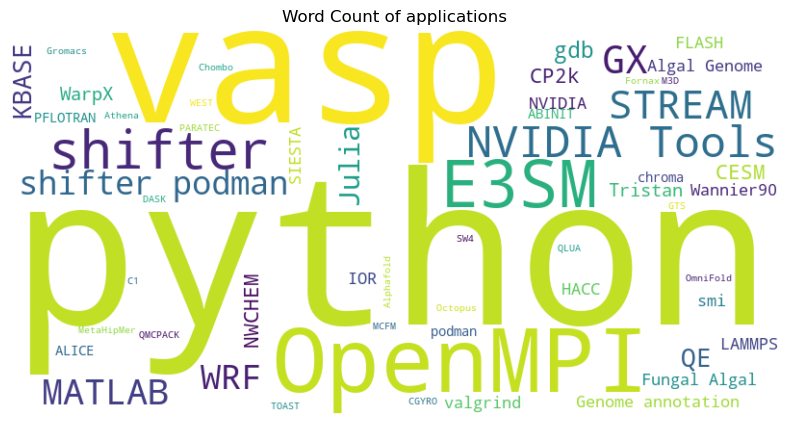

In [17]:
#Word Cloud Visuals 

# Combining all the matches into a single string
all_matches = ' '.join([' '.join(match) if isinstance(match, list) else match for match in filtered_data['Applications']])

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_matches)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Count of applications')
plt.show()




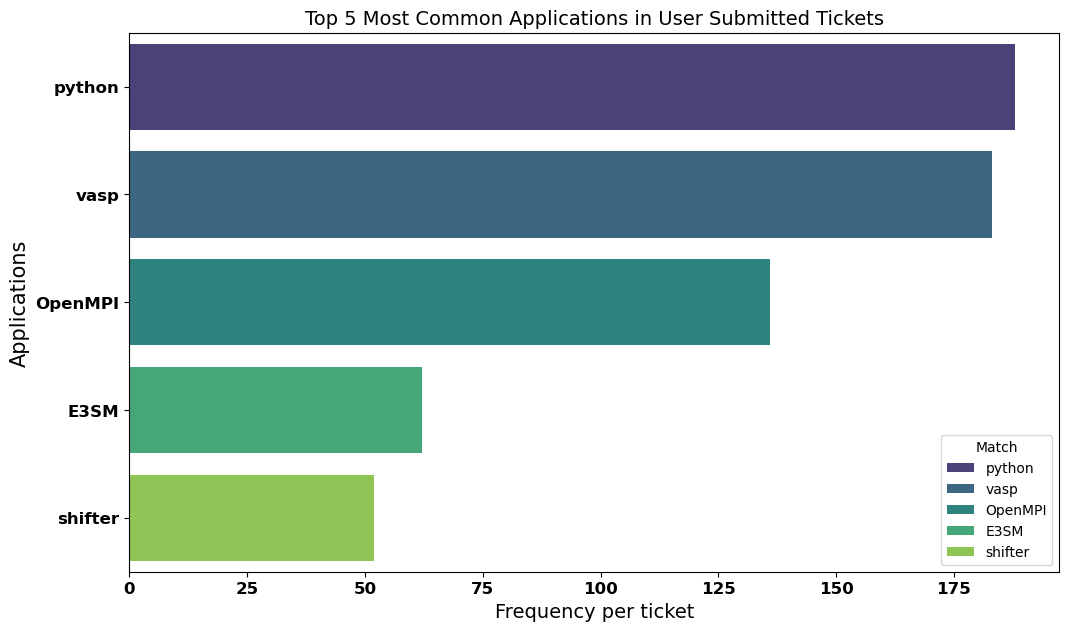

In [18]:
# Bar Plot of Most Common Applications

# Flatten the list of matches and count the occurrences of each match
flattened_matches = [match for sublist in filtered_data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
match_counts = Counter(flattened_matches)

# Converting to a DataFrame for plotting
match_counts_df = pd.DataFrame(match_counts.items(), columns=['Match', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top N most common words
N = 5
top_n_words = match_counts_df.head(N)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Match', data=top_n_words, palette='viridis', hue='Match',legend=True, dodge=False)
plt.xlabel('Frequency per ticket', fontsize=14)
plt.ylabel('Applications', fontsize=15)
plt.title(f'Top {N} Most Common Applications in User Submitted Tickets',fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()



In [19]:
# 2D PREP
patterns2 = {
    "login": r"(?i)\blogin\b",
    "license": r"(?i)\blicense\b",
    "password": r"(?i)\bpassword\b",
    "error": r"(?i)\berror\b",
    "crash": r"(?i)\bcrash\b",
    "configuration": r"(?i)\bconfiguration\b",
    "backup": r"(?i)\bbackup\b",
    "restore": r"(?i)\brestore\b",
    "network outage": r"(?i)\bnetwork\boutage\b",
    "log-in": r"(?i)\blog-in\b",
    "activation": r"activation",
    "blocked": r"(?i)\bblocked\b",
    "locked": r"(?i)\blocked\b",
    "approval": r"(?i)\bapproval\b",
    "mfa": r"(?i)\bmfa\b"
    #"alloacation_year": r"\ballocation year\b"
}

compiled_patterns2 = {
    name: re.compile(pattern, re.IGNORECASE)
    for name, pattern in patterns2.items()
}

In [20]:
def match(string, patterns):
    issues = []
    for name, pattern in patterns.items():
        #print(name)
        #print(matches)
        if pattern.search(string):
            #print("found", name)
            issues.append(name) 
    return issues

def f(x):
    return match(x, compiled_patterns2)

In [21]:
%%time
names2 = process_map(f, data['text_data'], max_workers=32, chunksize=1000) #play with the numbers

  0%|          | 0/2816 [00:00<?, ?it/s]

CPU times: user 52.6 ms, sys: 295 ms, total: 348 ms
Wall time: 1.23 s


In [22]:
#names2

In [23]:
data = pd.DataFrame(data)


In [24]:
data.head()

,ID,Created,Applications,text_data
0,197059,2023-01-18 04:39:28,[],043928 scratch purge extension 020005 - system...
1,197077,2023-01-18 07:34:40,[],073440 nersc account new allocation year 02000...
2,197078,2023-01-18 07:34:43,[],073443 nersc account new allocation year 02000...
3,197079,2023-01-18 07:34:45,[],073445 nersc account new allocation year 02000...
4,197080,2023-01-18 07:38:44,[],073844 nersc account new allocation year 02000...


In [25]:
data.insert(2,"Issues",names2,True)

In [26]:
#data

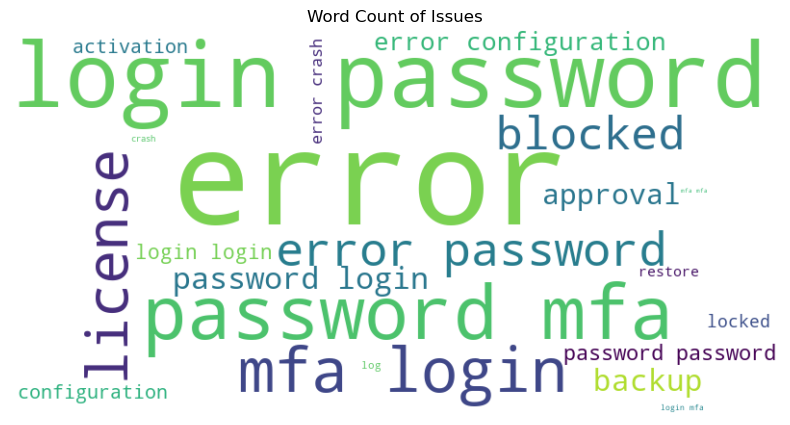

In [27]:
#Word Cloud Visuals 

# Combining all the matches into a single string
all_matches = ' '.join([' '.join(match) if isinstance(match, list) else match for match in data['Issues']])

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_matches)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Count of Issues')
plt.show()



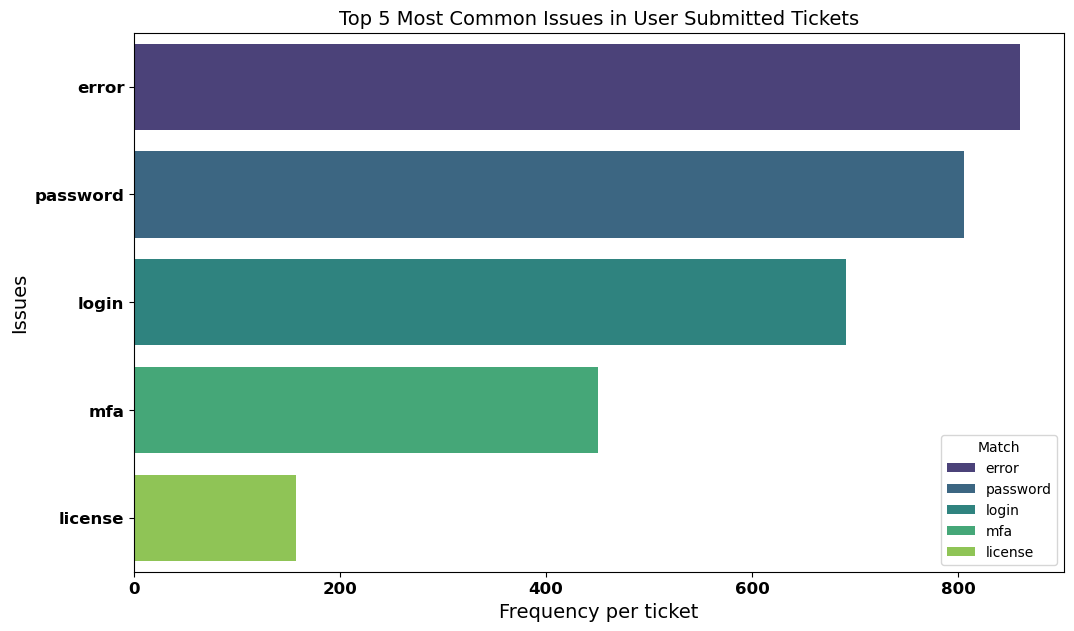

In [28]:
# Bar Plot of Most Common Words

# Flatten the list of matches and count the occurrences of each match
flattened_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]
match_counts = Counter(flattened_matches)

# Converting to a DataFrame for plotting
match_counts_df = pd.DataFrame(match_counts.items(), columns=['Match', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top N most common words
N = 5
top_n_words = match_counts_df.head(N)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Match', data=top_n_words, palette='viridis', hue='Match',legend=True, dodge=False)
plt.xlabel('Frequency per ticket',fontsize=14)
plt.ylabel('Issues', fontsize=14)
plt.title(f'Top {N} Most Common Issues in User Submitted Tickets', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()


In [29]:
applications_keywords = [match for sublist in filtered_data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
issues_keywords = flattened_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]
    

In [30]:
# matches and count the occurrences of each application match
flattened_app_matches = [match for sublist in data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
app_match_counts = Counter(flattened_app_matches)

In [31]:
 #  matches and count the occurrences of each issue match
flattened_issue_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]
issue_match_counts = Counter(flattened_issue_matches)

In [32]:
# matrix for the heatmap
heatmap_matrix = pd.DataFrame(0, index=applications_keywords, columns=issues_keywords)


In [33]:
# matrix for the heatmap
#print(heatmap_matrix) 

In [34]:
# Populate the matrix with counts
for _, row in data.iterrows():
    for app in row['Applications']:
        for issue in row['Issues']:
             if app in applications_keywords and issue in issues_keywords:
                heatmap_matrix.loc[app, issue] += 1


In [35]:
# Plot the heatmap
#plt.figure(figsize=(12, 8))
#sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap="YlGnBu")
#plt.title("Keyword Occurrences in Issues and Applications")
#plt.xlabel("Issues")
#plt.ylabel("Applications")
#plt.show()


In [36]:
data.to_parquet("/pscratch/sd/m/masare/sacct/perlmutter/data.updated.parquet")

In [37]:
data.head()

,ID,Created,Issues,Applications,text_data
0,197059,2023-01-18 04:39:28,[],[],043928 scratch purge extension 020005 - system...
1,197077,2023-01-18 07:34:40,[error],[],073440 nersc account new allocation year 02000...
2,197078,2023-01-18 07:34:43,[error],[],073443 nersc account new allocation year 02000...
3,197079,2023-01-18 07:34:45,[error],[],073445 nersc account new allocation year 02000...
4,197080,2023-01-18 07:38:44,[error],[],073844 nersc account new allocation year 02000...


In [38]:
data['text_data'][1]

'073440 nersc account new allocation year 020005 - system (additional comments) incident automatically closed 7 day resolved state. 102608 - system (additional comments) incident automatically resolved 14 day waiting user reply. 084738 - mark pederson (additional comments) reply mrpederson@utep.edu thanks! [utep] mark r pederson phd faps professor chairman dr. c. sharp cook chair physic department physic psci 209a university texas el paso 500 w. university ave. el paso tx 79968 office 915-747-8869 www.utep.edu/science/physics<> 084202 - clayton bagwell (additional comments) mark likely pi mark account continue new allocation year (ay). pi need log iris go role tab project. far right-hand side page button titled "from last year". click button get list user associated project last year click checkboxes next name add back project year finally click "ok" bottom page. sincerely clayton bagwell (gender pronoun he/him/his) account allocation support land live work ancestral unceded territory 

In [39]:
def count_occurrences(text, patterns):
    """
    Counts occurrences of each pattern in the given text.
    
    Parameters:
    text (str): The text to search.
    patterns (dict): A dictionary of compiled regex patterns.
    
    Returns:
    dict: A dictionary with counts for each pattern.
    """
    counts = {key: 0 for key in patterns}
    for key, pattern in patterns.items():
        counts[key] += len(pattern.findall(text))
    return counts


In [40]:
def create_issue_application_matrix(data, issues, applications):
    """
    Creates a 2D matrix for issues and applications.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing 'text_data' column.
    issues (dict): Dictionary of compiled regex patterns for issues.
    applications (dict): Dictionary of compiled regex patterns for applications.
    
    Returns:
    pd.DataFrame: A DataFrame representing the 2D matrix.
    """
    # Initialthe matrix
    matrix = pd.DataFrame(0, index=applications.keys(), columns=issues.keys())
    
    # Process each row in the data
    for text in data['text_data']:  # Use existing 'text_data' column
        issue_counts = count_occurrences(text, issues)
        application_counts = count_occurrences(text, applications)
        
        for app, app_count in application_counts.items():
            if app_count > 0:
                for issue, issue_count in issue_counts.items():
                    matrix.loc[app, issue] += issue_count
    
    return matrix

In [41]:
def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.
    
    Parameters:
    matrix (pd.DataFrame): DataFrame representing the 2D matrix.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Occurrences of Issues in Applications")
    plt.xlabel("Issues")
    plt.ylabel("Applications")
    plt.show()


In [42]:

# first 20 applications and first 10 issues
limited_applications = dict(list(compiled_patterns.items())[:20])
limited_issues = dict(list(compiled_patterns2.items())[:20])


matrix = create_issue_application_matrix(data, limited_issues, limited_applications)

In [43]:
matrix


,login,license,password,error,crash,configuration,backup,restore,network outage,log-in,activation,blocked,locked,approval,mfa
python,246,36,42,1145,20,78,6,2,0,0,2,4,6,10,42
GPD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EXCESS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WEST,0,0,0,16,2,0,0,0,0,0,0,0,0,0,0
vasp,37,1290,38,649,33,16,12,2,0,0,0,4,4,0,15
CP2k,0,0,2,59,2,2,2,0,0,0,0,0,0,0,0
QE,2,0,0,156,21,2,0,0,0,0,0,0,0,0,0
LAMMPS,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0
NWCHEM,0,0,13,103,0,0,2,0,0,0,0,0,0,0,13
JDFTx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


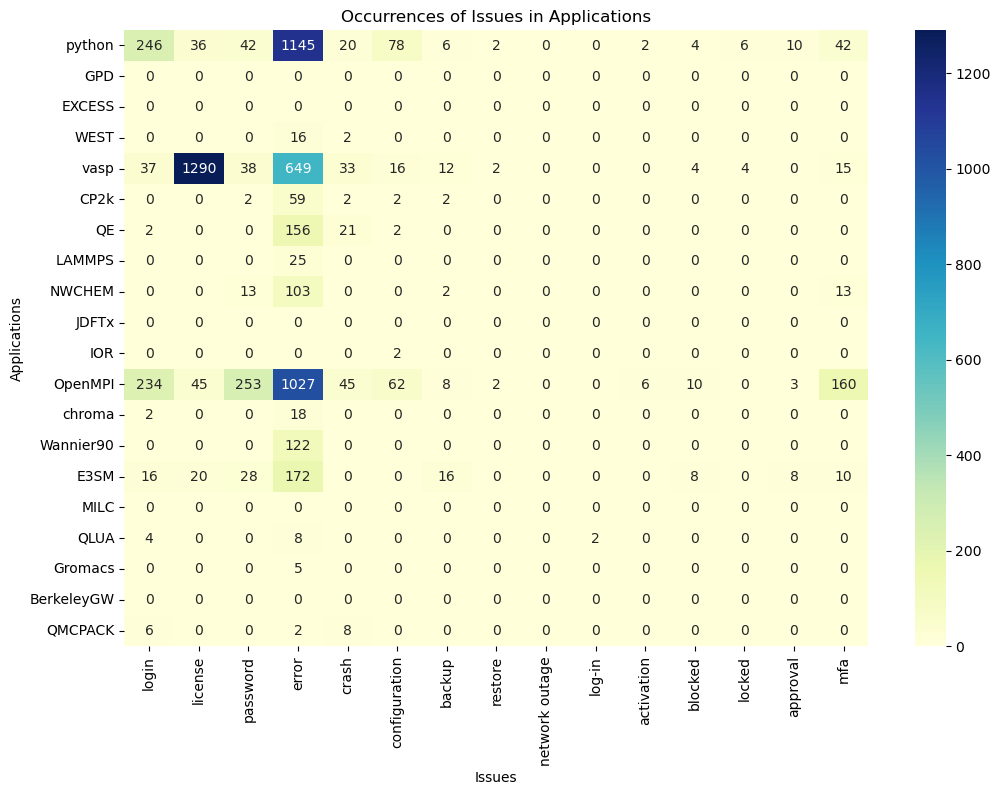

In [44]:
plot_heatmap(matrix)

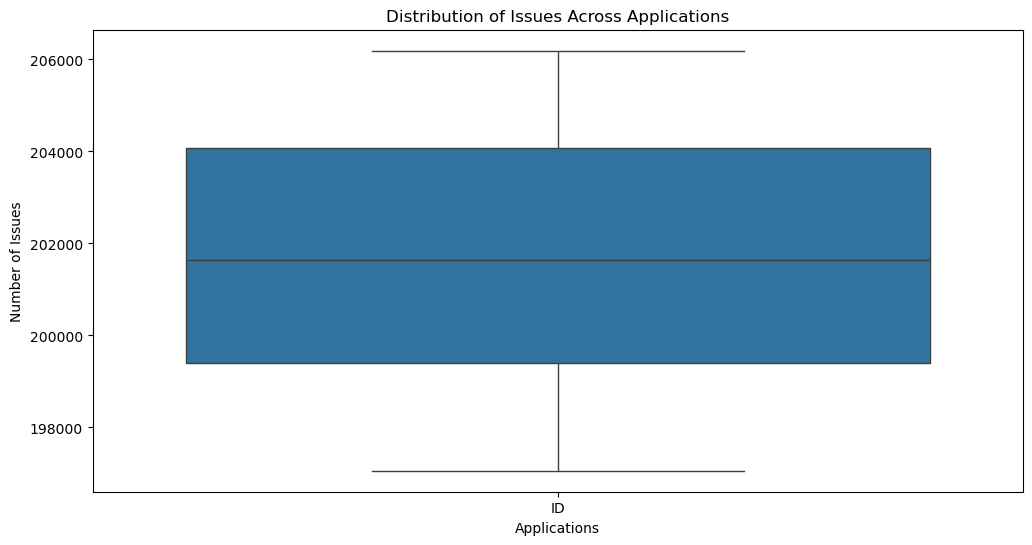

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.title('Distribution of Issues Across Applications')
plt.xlabel('Applications')
plt.ylabel('Number of Issues')
plt.show()




In [46]:
# Convert 'Created' column to datetime
data['Created'] = pd.to_datetime(data['Created'])


# Convert list-like strings in 'Issues' and 'Applications' columns to actual lists
data['Issues'] = data['Issues'].apply(lambda x: eval(x) if isinstance(x, str) else x)
data['Applications'] = data['Applications'].apply(lambda x: eval(x) if isinstance(x, str) else x)


# Check the data
print(data.head())


       ID             Created   Issues Applications  \
0  197059 2023-01-18 04:39:28       []           []   
1  197077 2023-01-18 07:34:40  [error]           []   
2  197078 2023-01-18 07:34:43  [error]           []   
3  197079 2023-01-18 07:34:45  [error]           []   
4  197080 2023-01-18 07:38:44  [error]           []   

                                           text_data  
0  043928 scratch purge extension 020005 - system...  
1  073440 nersc account new allocation year 02000...  
2  073443 nersc account new allocation year 02000...  
3  073445 nersc account new allocation year 02000...  
4  073844 nersc account new allocation year 02000...  


In [47]:
# Count the frequency of each issue
issue_counts = data['Issues'].explode().value_counts()


# Count the frequency of each application
application_counts = data['Applications'].explode().value_counts()


print("Issue Counts:\n", issue_counts)
print("Application Counts:\n", application_counts)

Issue Counts:
 Issues
error            860
password         806
login            691
mfa              450
license          157
configuration    111
blocked           97
backup            82
approval          75
activation        39
crash             37
locked            32
restore           24
log-in            12
Name: count, dtype: int64
Application Counts:
 Applications
python                            188
vasp                              183
OpenMPI                           136
E3SM                               62
shifter                            52
NVIDIA Tools                       25
STREAM                             21
GX                                 20
MATLAB                             17
podman                             16
WRF                                15
Julia                              10
KBASE                               8
QE                                  8
gdb                                 6
CP2k                                5
CESM            

<Figure size 2000x900 with 0 Axes>

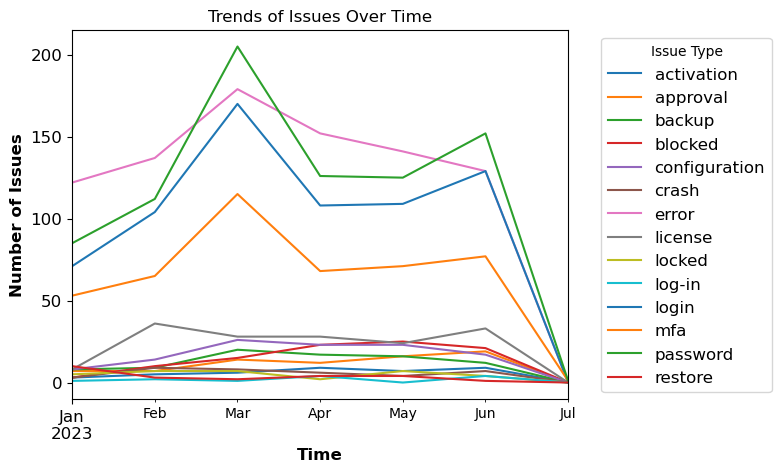

In [48]:
# Create a new DataFrame for issues over time
issues_over_time = data.explode('Issues').groupby([data['Created'].dt.to_period('M'), 'Issues']).size().unstack().fillna(0)


# Plot the trends
plt.figure(figsize=(20, 9))
issues_over_time.plot()
plt.title('Trends of Issues Over Time')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Number of Issues',fontsize=12, fontweight='bold')
plt.legend(title='Issue Type')
plt.legend(title='Issue Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


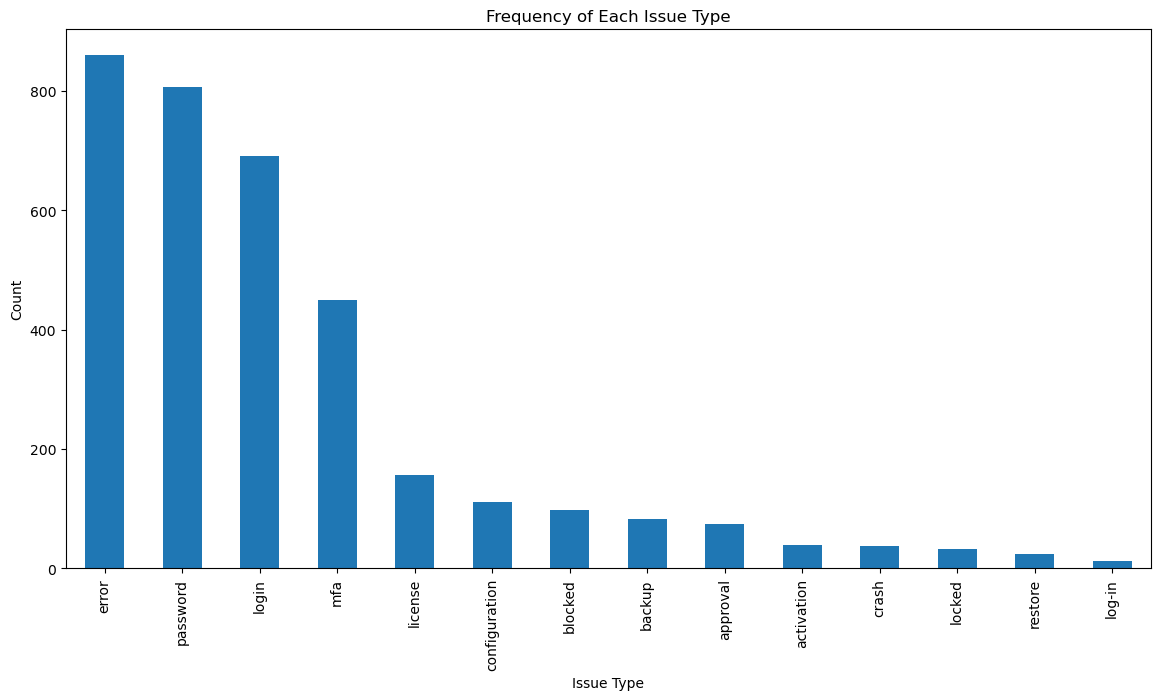

In [49]:
issue_counts.plot(kind='bar', figsize=(14, 7))
plt.title('Frequency of Each Issue Type')
plt.xlabel('Issue Type')
plt.ylabel('Count')
plt.show()

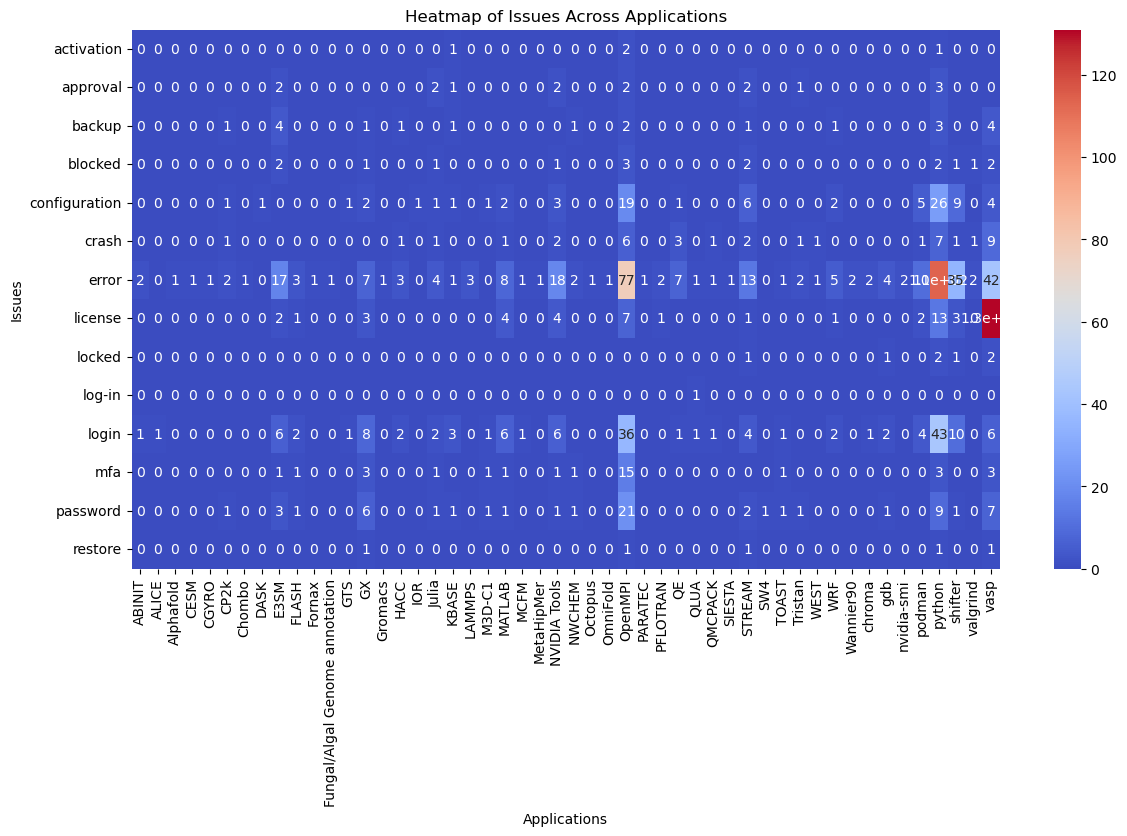

In [50]:
# Create a matrix of issues vs applications
issue_app_matrix = data.explode('Issues').explode('Applications').pivot_table(index='Issues', columns='Applications', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 7))
sns.heatmap(issue_app_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Issues Across Applications')
plt.xlabel('Applications')
plt.ylabel('Issues')
plt.show()


In [51]:
#the above analysis is for the entire dataset, now to analyze for each user, lets see below

In [52]:
user_stats = data.groupby('ID').apply(lambda df: pd.Series({
    'Total Issues': df['Issues'].explode().nunique(),
    'Total Applications': df['Applications'].explode().nunique(),
    'Total Entries': df.shape[0]
}))


#print(user_stats)


In [53]:
# Explode the Issues and Applications columns
data = data.explode('Issues').explode('Applications') #this transforms issues and application columns into separate rows for easy normalization

In [54]:
print(data.head())

       ID             Created Issues Applications  \
0  197059 2023-01-18 04:39:28    NaN          NaN   
1  197077 2023-01-18 07:34:40  error          NaN   
2  197078 2023-01-18 07:34:43  error          NaN   
3  197079 2023-01-18 07:34:45  error          NaN   
4  197080 2023-01-18 07:38:44  error          NaN   

                                           text_data  
0  043928 scratch purge extension 020005 - system...  
1  073440 nersc account new allocation year 02000...  
2  073443 nersc account new allocation year 02000...  
3  073445 nersc account new allocation year 02000...  
4  073844 nersc account new allocation year 02000...  


In [55]:
pivot_table = data.pivot_table(index='Applications', columns='Issues', aggfunc='size', fill_value=0) 
pivot_table = pivot_table.reset_index()
print(pivot_table)

Issues                    Applications  activation  approval  backup  blocked  \
0                               ABINIT           0         0       0        0   
1                                ALICE           0         0       0        0   
2                            Alphafold           0         0       0        0   
3                                 CESM           0         0       0        0   
4                                CGYRO           0         0       0        0   
5                                 CP2k           0         0       1        0   
6                               Chombo           0         0       0        0   
7                                 DASK           0         0       0        0   
8                                 E3SM           0         2       4        2   
9                                FLASH           0         0       0        0   
10                              Fornax           0         0       0        0   
11      Fungal/Algal Genome 

In [56]:
# Subset the pivot table to first 20 rows and columns 
pivot_table_subset = pivot_table.head(5).iloc[:, :5] 

In [57]:
print(pivot_table_subset)

Issues Applications  activation  approval  backup  blocked
0            ABINIT           0         0       0        0
1             ALICE           0         0       0        0
2         Alphafold           0         0       0        0
3              CESM           0         0       0        0
4             CGYRO           0         0       0        0


In [58]:
from tabulate import tabulate
# Format the table using tabulate
formatted_table = tabulate(pivot_table_subset, headers='keys', tablefmt='grid')
print(formatted_table)


+----+----------------+--------------+------------+----------+-----------+
|    | Applications   |   activation |   approval |   backup |   blocked |
+====+================+==============+============+==========+===========+
|  0 | ABINIT         |            0 |          0 |        0 |         0 |
+----+----------------+--------------+------------+----------+-----------+
|  1 | ALICE          |            0 |          0 |        0 |         0 |
+----+----------------+--------------+------------+----------+-----------+
|  2 | Alphafold      |            0 |          0 |        0 |         0 |
+----+----------------+--------------+------------+----------+-----------+
|  3 | CESM           |            0 |          0 |        0 |         0 |
+----+----------------+--------------+------------+----------+-----------+
|  4 | CGYRO          |            0 |          0 |        0 |         0 |
+----+----------------+--------------+------------+----------+-----------+


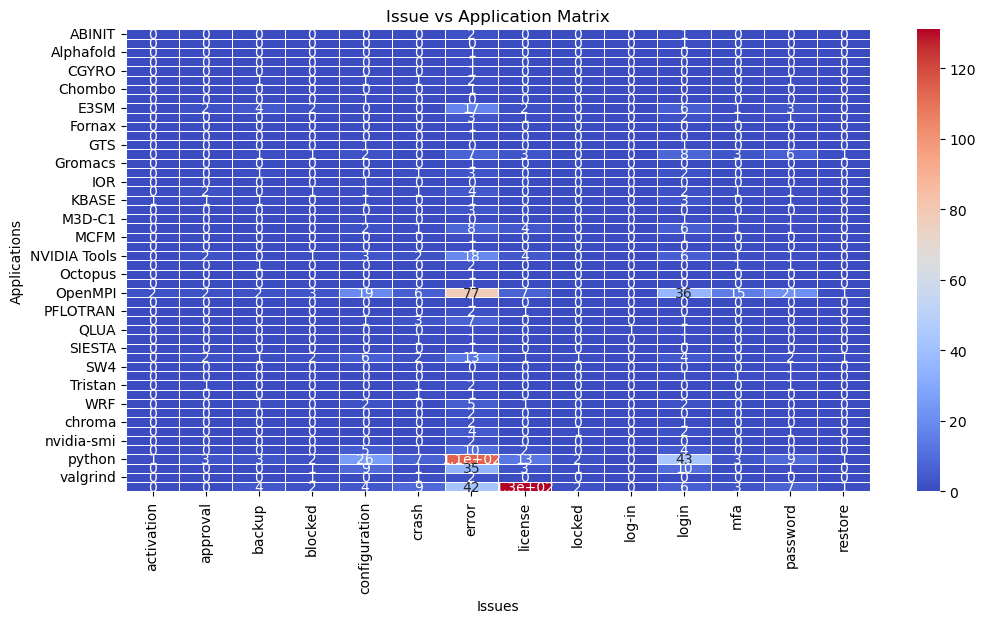

In [59]:
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table.set_index('Applications'), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Issue vs Application Matrix')
plt.xlabel('Issues')
plt.ylabel('Applications')
plt.show()

In [60]:
# Count occurrences of each issue per application
issue_app_counts = data.groupby(['Applications', 'Issues']).size().unstack(fill_value=0)


# Sum occurrences to sort by frequency
issue_counts = issue_app_counts.sum(axis=0).sort_values(ascending=False)
application_counts = issue_app_counts.sum(axis=1).sort_values(ascending=False)


# Reorder the pivot table based on the most frequent issues and applications
issue_app_counts = issue_app_counts.loc[application_counts.index, issue_counts.index]


# Display the matrix as a DataFrame
issue_app_matrix = issue_app_counts


print("Issue vs Application Matrix:")
issue_app_matrix




Issue vs Application Matrix:


Issues,error,license,login,configuration,password,crash,mfa,backup,blocked,approval,locked,restore,activation,log-in
Applications,,,,,,,,,,,,,,
python,114,13,43,26,9,7,3,3,2,3,2,1,1,0
vasp,42,131,6,4,7,9,3,4,2,0,2,1,0,0
OpenMPI,77,7,36,19,21,6,15,2,3,2,0,1,2,0
shifter,35,3,10,9,1,1,0,0,1,0,1,0,0,0
NVIDIA Tools,18,4,6,3,1,2,1,0,1,2,0,0,0,0
E3SM,17,2,6,0,3,0,1,4,2,2,0,0,0,0
STREAM,13,1,4,6,2,2,0,1,2,2,1,1,0,0
GX,7,3,8,2,6,0,3,1,1,0,0,1,0,0
MATLAB,8,4,6,2,1,1,1,0,0,0,0,0,0,0


In [61]:
# Count occurrences of each issue per application
issue_app_counts = data.groupby(['Applications', 'Issues']).size().unstack(fill_value=0)


# Sum occurrences to sort by frequency
issue_counts = issue_app_counts.sum(axis=0).sort_values(ascending=False)
application_counts = issue_app_counts.sum(axis=1).sort_values(ascending=False)


# Reorder the pivot table based on the most frequent issues and applications
issue_app_counts = issue_app_counts.loc[application_counts.index, issue_counts.index]


# Display the matrix as a DataFrame
issue_app_matrix = issue_app_counts


print("Issue vs Application Matrix:")
issue_app_matrix


Issue vs Application Matrix:


Issues,error,license,login,configuration,password,crash,mfa,backup,blocked,approval,locked,restore,activation,log-in
Applications,,,,,,,,,,,,,,
python,114,13,43,26,9,7,3,3,2,3,2,1,1,0
vasp,42,131,6,4,7,9,3,4,2,0,2,1,0,0
OpenMPI,77,7,36,19,21,6,15,2,3,2,0,1,2,0
shifter,35,3,10,9,1,1,0,0,1,0,1,0,0,0
NVIDIA Tools,18,4,6,3,1,2,1,0,1,2,0,0,0,0
E3SM,17,2,6,0,3,0,1,4,2,2,0,0,0,0
STREAM,13,1,4,6,2,2,0,1,2,2,1,1,0,0
GX,7,3,8,2,6,0,3,1,1,0,0,1,0,0
MATLAB,8,4,6,2,1,1,1,0,0,0,0,0,0,0
